# $\color{red}{\text{DL Final Project: MRI Tumor Detection}}$

# $\color{blue}{\text{Imports and load}}$
<!-- 
<h1 style="background-color:Green;">
Data Preparation
</h1> -->


<h2 style="background-color:DodgerBlue;">
Necessary imports and Load dataset
</h2>



In [5]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warnings
import warnings
warnings.filterwarnings('ignore')

<h2 style="background-color:DodgerBlue;">
Unzip dataset, review, and split to train and test
</h2>



In [41]:
# !unzip -qo /kaggle/input/dogs-vs-cats/train.zip 
# !unzip -qo /kaggle/input/dogs-vs-cats/test1.zip

In [46]:
path , dirs , files = next(os.walk('/kaggle/working/train'))
file_count = len(files)
print(file_count)

25000


In [ ]:
base_dir = '/kaggle/working/dogs_vs_cats_small'
os.mkdir(base_dir)

In [ ]:
train_dir = os.path.join(base_dir , 'train')
os.mkdir(train_dir) #make a new train directory inside my base directory

valid_dir= os.path.join(base_dir , 'validation')
os.mkdir(valid_dir) #make a new validation directory inside my base directory

test_dir = os.path.join(base_dir , 'test')
os.mkdir(test_dir) #make a new test directory inside my base directory

train_cats_dir = os.path.join(train_dir , 'cats')
os.mkdir(train_cats_dir) #make a new cats directory inside my train directory

train_dogs_dir = os.path.join(train_dir , 'dogs')
os.mkdir(train_dogs_dir) #make a new dogs directory inside my train directory

valid_cats_dir = os.path.join(valid_dir, 'cats')
os.mkdir(valid_cats_dir) #make a new cats directory inside my validation directory

valid_dogs_dir = os.path.join(valid_dir , 'dogs')
os.mkdir(valid_dogs_dir) #make a new dogs directory inside my validation directory

test_cats_dir = os.path.join(test_dir , 'cats')
os.mkdir(test_cats_dir) #make a new cats directory inside my test directory

test_dogs_dir = os.path.join(test_dir , 'dogs')
os.mkdir(test_dogs_dir) #make a new dogs directory inside my test directory

In [49]:
dir_path = '/kaggle/working/train'

cat_count = 0
dog_count= 0
for i in os.listdir(dir_path):
    if i.startswith('cat.'):
        cat_count += 1
    elif i.startswith('dog.'):
        dog_count += 1
        
print(f"Number of cat images: {cat_count}")
print(f"Number of dog images: {dog_count}")

Number of cat images: 12500
Number of dog images: 12500


In [50]:
original_dataset_dir = '/kaggle/working/train'

fnames = ['cat.{}.jpg'.format(i) for i in range(10001)] #Move 10,000 cat images from the original dataset to the train cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(train_cats_dir , fname)
  shutil.copyfile(src , dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(10001,11251)] #Move 1250 cat images from the original dataset to the validation cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(valid_cats_dir , fname)
  shutil.copyfile(src,dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(11251,12500)] #Move 1250 cat images from the original dataset to the test cat directory
for fname in fnames:
  src= os.path.join(original_dataset_dir , fname)
  dst= os.path.join(test_cats_dir, fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10001)] #Move 10,000 dog images from the original dataset to the train cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(train_dogs_dir ,fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10001,11251)] #Move 1250 dog images from the original dataset to the validation cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir,fname)
  dst = os.path.join(valid_dogs_dir , fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(11251,12500)]#Move 1250 dog images from the original dataset to the test cat directory
for fname in fnames:
  src= os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir , fname)
  shutil.copyfile(src, dst)

In [51]:
print(f'Total training cat images {len(os.listdir(train_cats_dir))}')
print(f'Total validation cat images {len(os.listdir(valid_cats_dir))}')
print(f'Total test cat images {len(os.listdir(test_cats_dir))}')
print('\n')
print(f'Total training dog images {len(os.listdir(train_dogs_dir))}')
print(f'Total validation cat images {len(os.listdir(valid_dogs_dir))}')
print(f'Total test cat images {len(os.listdir(test_dogs_dir))}')

Total training cat images 10001
Total validation cat images 1250
Total test cat images 1249


Total training dog images 10001
Total validation cat images 1250
Total test cat images 1249


<h2 style="background-color:Orange;">
Rain, snow, mist, and noise to images
</h2>



In [53]:
import cv2
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Constants
img_size = (224, 224)
batch_size = 32
img_shape = (img_size[0], img_size[1], 3)


# Define weather effects functions
def add_snow(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(image_hsv, (0, 0, 0), (180, 20, 255))
    snow = np.random.randint(10, 50, image.shape, dtype='uint8')
    snow[mask != 0] = 255

    # Convert image to uint8 data type to match snow array
    image = image.astype(np.uint8)
    
    return cv2.add(image, snow)

def add_rain(image):
    # Convert the input image to HSV color space
    image_HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Adjust the brightness of the image (optional)
    brightness = 0.8
    image_HSV[..., 2] = image_HSV[..., 2] * brightness
    
    # Generate random raindrops
    rain_drops = np.zeros_like(image)
    raindrop_intensity = 0.2  # Intensity of raindrops, adjust as needed
    
    # Generate random coordinates for raindrops
    num_drops = int(image.shape[0] * image.shape[1] * raindrop_intensity)
    for _ in range(num_drops):
        x = np.random.randint(0, image.shape[1])
        y = np.random.randint(0, image.shape[0])
        brightness = np.random.randint(200, 255)
        rain_drops[y, x] = brightness
    
    # Add raindrops to the image
    image_with_rain = cv2.add(image, rain_drops)
    
    return image_with_rain

def add_mist(image):
    # Generate mist as a 3-channel grayscale image
    mist = np.random.randint(150, 200, size=image.shape[:2], dtype='uint8')
    mist = cv2.merge([mist, mist, mist])  # Convert mist to 3-channel grayscale

    alpha = 0.6  # Opacity of the mist, adjust as needed
    
    # Create a mask using the mist image
    mask = (mist.astype(float) * alpha / 255.0).astype(np.uint8)  # Convert mask to uint8 data type
    
    # Convert the input image to the same data type as mask before blending
    image = image.astype(np.uint8)
    
    # Blend the mist with the input image
    image_with_mist = cv2.addWeighted(image, 1 - alpha, mask, alpha, 0)
    
    return image_with_mist

def add_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 80
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    
    # Add the generated noise to the input image and clip values to the valid range [0, 255]
    noisy = np.clip(image + gauss, 0, 255)
    
    # Convert the noisy image to uint8 data type
    noisy = noisy.astype(np.uint8)
    
    return noisy

In [54]:
def random_preprocessing(image):
    # List of preprocessing functions
    preprocessing_functions = [add_noise, add_mist, add_rain, add_snow]
    
    # Randomly select a preprocessing function from the list
    selected_function = random.choice(preprocessing_functions)
    
    # Apply the randomly selected preprocessing function to the input image
    return selected_function(image)

# Create ImageDataGenerator with the random preprocessing function
tr_gen = ImageDataGenerator(preprocessing_function=random_preprocessing)



# Image data generator with weather effects preprocessing functions
# tr_gen = ImageDataGenerator(preprocessing_function=add_noise)

# Image data generator for loading and augmenting images
train_gen = tr_gen.flow_from_directory(train_dir, target_size=img_size, class_mode='binary',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)


Found 20002 images belonging to 2 classes.


Found 20002 images belonging to 2 classes.


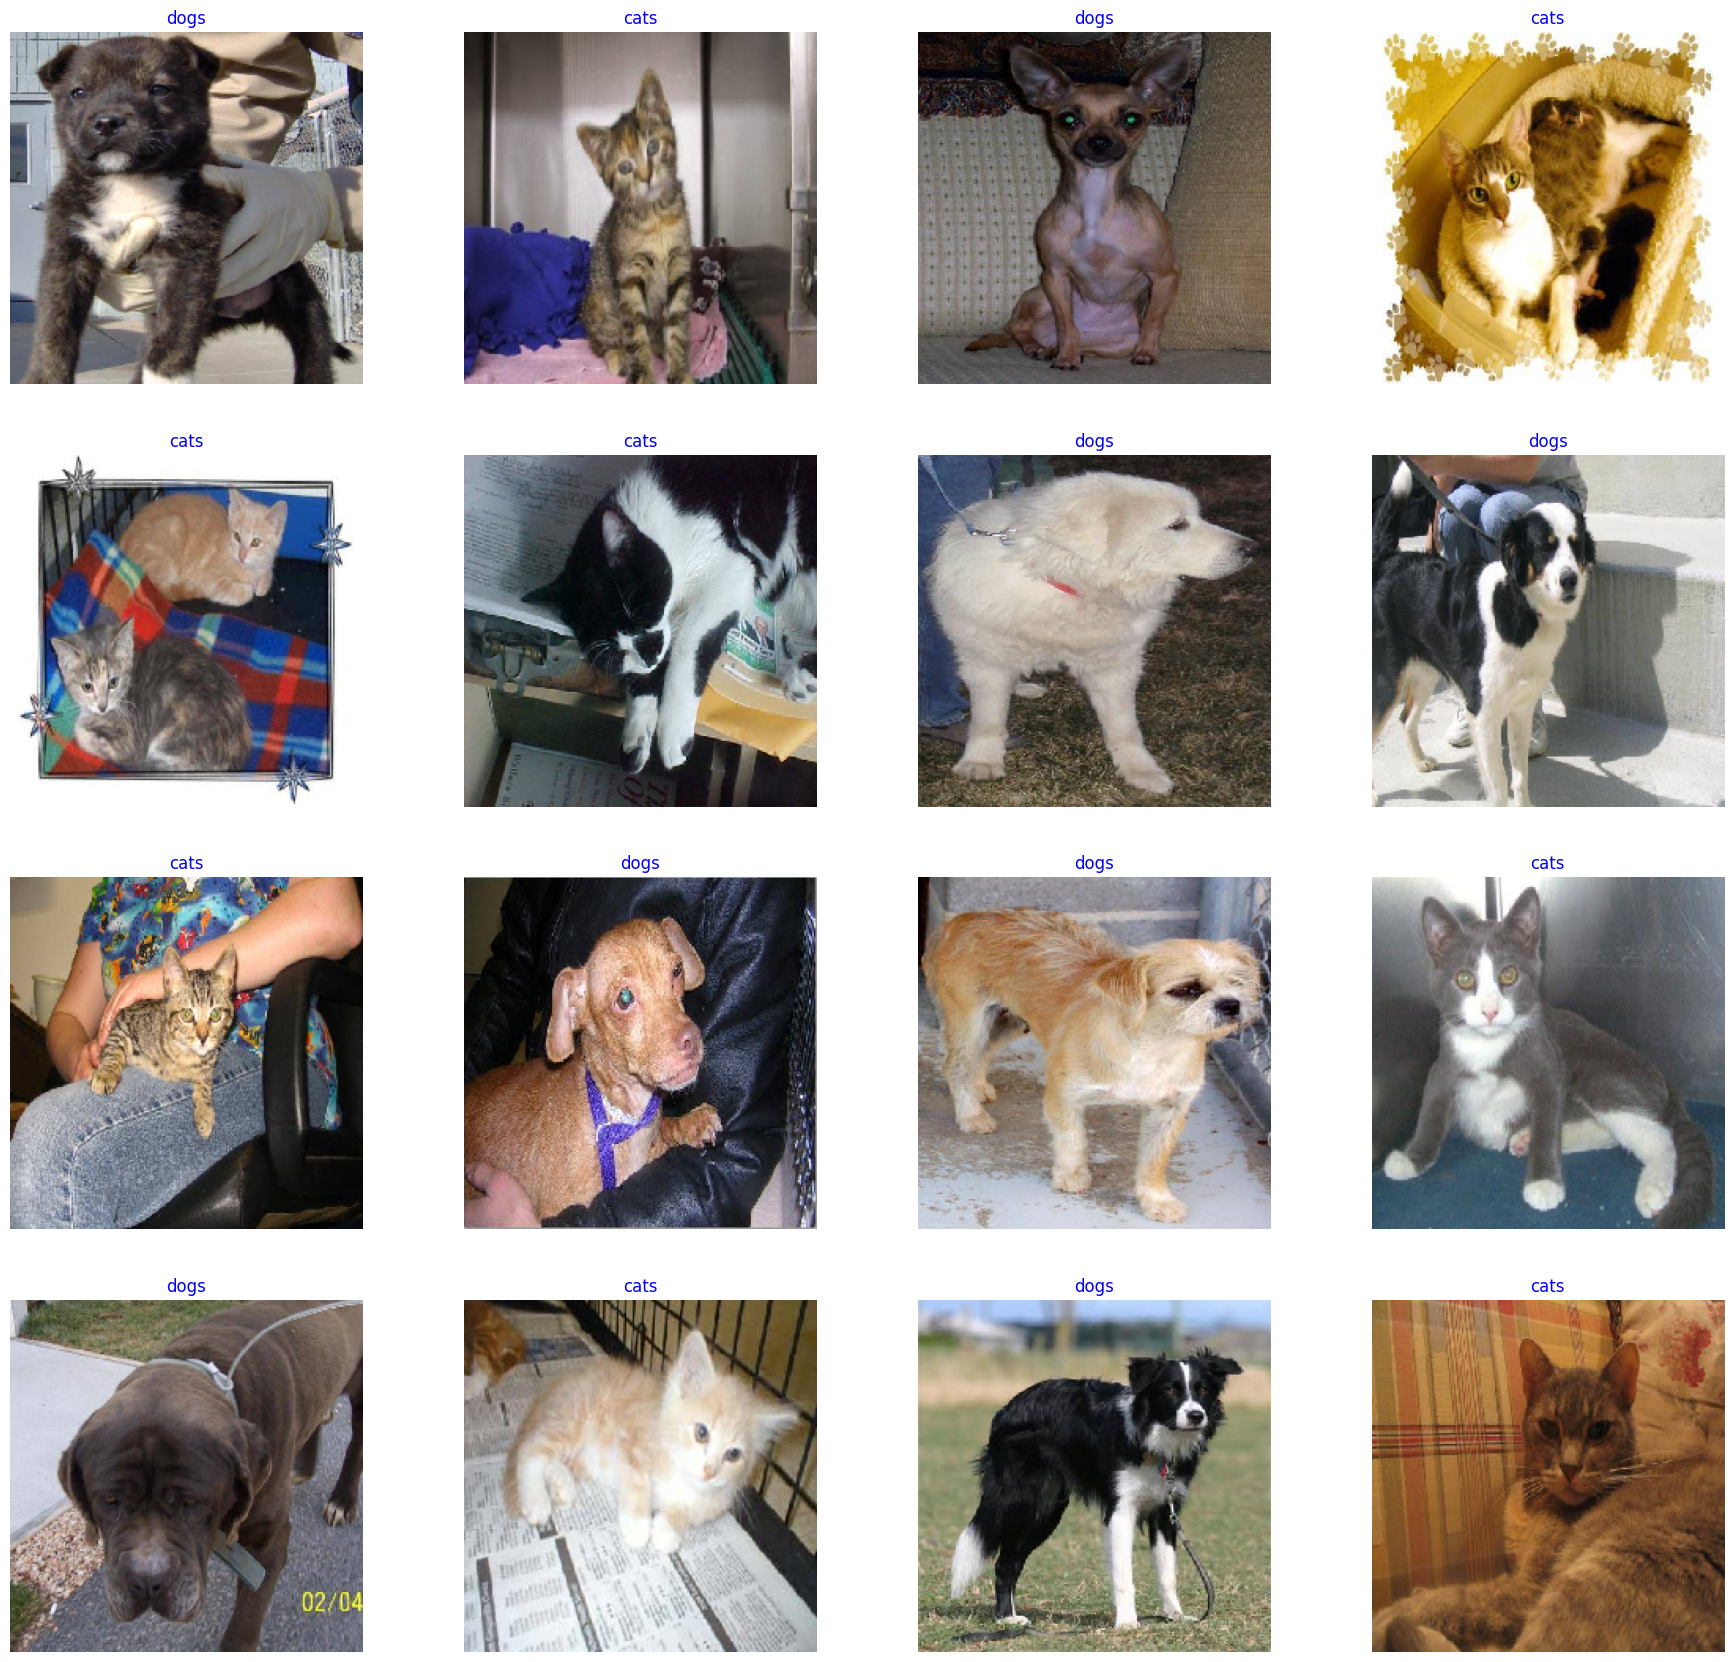

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def preprocess_images(images):
    preprocessed_images = []
    for i in range(len(images)):
        image = images[i]
        
        # Convert the BGR image to LAB color space
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
#         # Split the LAB image into L, A, and B channels
        r, g, b = cv2.split(img)
#         print(r)
    
        # Ensure the channels have the correct data type (8-bit unsigned)
        r = r.astype(np.uint8)
        g = g.astype(np.uint8)
        b = b.astype(np.uint8)
        
        # Apply CLAHE to each channel separately
        clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8,8))
        r = clahe.apply(r)
        g = clahe.apply(g)
        b = clahe.apply(b)

        # Merge the enhanced RGB channels 
        img_output = cv2.merge([r, g, b])
        
       
        # Convert the LAB image back to BGR color space
        preprocessed_image = cv2.cvtColor(img_output, cv2.COLOR_RGB2BGR)
        
#         preprocessed_images.append(preprocessed_image)
        
        preprocessed_images.append(image)
    
    return np.array(preprocessed_images)

# Create an ImageDataGenerator instance with preprocessing functions and augmentation techniques
datagen = ImageDataGenerator(
#     rescale=1./255,  # Rescale pixel values to the range [0, 1]
#     rotation_range=20,  # Randomly rotate images by 20 degrees
#     width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the total width
#     height_shift_range=0.2,  # Randomly shift images vertically by 20% of the total height
#     shear_range=0.2,  # Shear intensity (counter-clockwise direction in radians)
#     zoom_range=0.2,  # Randomly zoom images by 20%
#     horizontal_flip=True,  # Randomly flip images horizontally
#     fill_mode='nearest',  # Fill mode for points outside the input boundary
    preprocessing_function=preprocess_images  # Custom preprocessing function using a median filter
)

# Assuming you have your training data in a directory, use flow_from_directory to create the generator
train_gen = datagen.flow_from_directory(
    train_dir,  # Specify your training data directory
    target_size=img_size,  # Target size for resizing the images
    class_mode='binary',  # 'binary' for binary classification, 'categorical' for multi-class classification
    color_mode='rgb',  # Use 'rgb' for 3-channel color images
    shuffle=True,  # Shuffle the data
    batch_size=batch_size  # Batch size
)

g_dict = train_gen.class_indices
classes = list(g_dict.keys())

# Retrieve a batch of images and labels from the generator
images, labels = next(train_gen)
num_samples = len(images)

# Plot the images with class names
plt.figure(figsize=(20, 20))
for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # Normalize pixel values to [0, 1]
    plt.imshow(image)
    class_index = int(labels[i])
    class_name = classes[class_index]  # Assuming you have defined 'classes' based on your dataset
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


In [56]:
img_size = (224 , 224)
batch_size = 64
print(batch_size)
img_shape = (img_size[0] , img_size[1] , 3)

# tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'binary' , 
#                                        color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(valid_dir , target_size = img_size , class_mode = 'binary' , 
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'binary' , 
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

64
Found 2500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


<h2 style="background-color:red;">
<!-- <div style="direction:rtl">  </div> -->
Making Model 
</h2>



In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50

img_shape = (img_size[0], img_size[1], 3)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
base_model.trainable = False

num_classes = len(classes)

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=40),
    Dense(1, activation='sigmoid')
])

model.compile(Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,120,705
Trainable params: 528,897
Non-trainable params: 23,591,808
____________________________________

<h2 style="background-color:red;">
<!-- <div style="direction:rtl">  </div> -->
Compile Model 
</h2>



In [23]:
history = model.fit(x= train_gen , validation_data= valid_gen , epochs= 1 , verbose = 1 , validation_steps = None , shuffle = False)

626/626 [==============================] - 1270s 2s/step - loss: 2.3034 - accuracy: 0.9611 - val_loss: 0.5695 - val_accuracy: 0.9760


<h2 style="background-color:Violet;">
<!-- <div style="direction:rtl">  </div> -->
Evaluate model
 </h2>



In [25]:
train_score = model.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 [==============================] - 7s 215ms/step - loss: 0.5725 - accuracy: 0.9761
Train loss = 0.5565281510353088
Train Accuracy = 0.9873046875
Validation loss = 0.5690115690231323
Validation Accuracy = 0.9775390625
Test loss = 0.5724592804908752
Test Accuracy = 0.97607421875


In [27]:
# Make predictions on the test set
preds = model.predict(test_gen)

# Convert the predictions to binary classes (0 or 1)
predicted_classes = (preds > 0.5).astype(int)

40/40 [==============================] - 9s 207ms/step


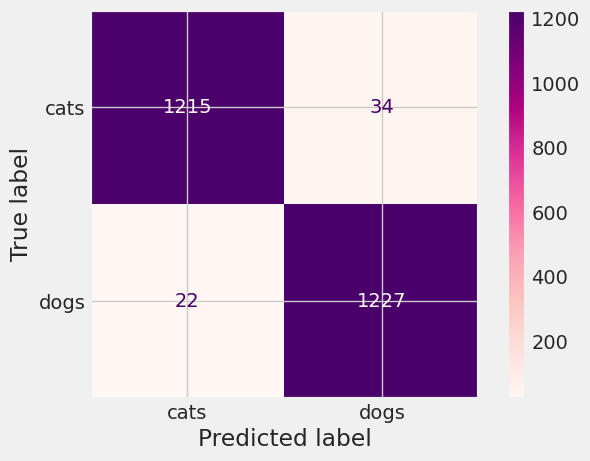

In [39]:
# Get the true labels from the generator
true_classes = test_gen.classes

# Calculate the confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=test_gen.class_indices)
disp.plot(cmap='RdPu', values_format='d')

In [37]:
# Generate and print the classification report
classification_rep = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices)
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

        cats       0.98      0.97      0.98      1249
        dogs       0.97      0.98      0.98      1249

    accuracy                           0.98      2498
   macro avg       0.98      0.98      0.98      2498
weighted avg       0.98      0.98      0.98      2498

